In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional
from sklearn.model_selection import train_test_split

In [2]:
album_path = "/content/drive/MyDrive/Colab_Notebooks/Outsystems/data/Albums"
text_data = []
for root, dirs, files in os.walk(album_path):
    for name in files:
        with open(os.path.join(root, name), mode="r", encoding="utf-8") as f:
            lines = f.readlines()[1:]
            # adding [EOS] at the end of each song
            lines = "".join(lines)
            text_data.append(lines)
            f.close()

In [3]:
# Splitting data into 80-10-10 data split
train, val = train_test_split(text_data, test_size=0.1, random_state=99)
train, test = train_test_split(train, test_size=0.1, random_state=99)

train_text = "".join(train).split("\n")
val_text = "".join(val).split("\n")
test_text = "".join(test).split("\n")

In [4]:
train_text[0]

'I want you to know'

In [5]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_text)
total_words = len(tokenizer.word_index) + 1

In [6]:
tokenizer.texts_to_sequences([train_text[0]])

[[3, 99, 2, 5, 27]]

In [7]:
def n_gram_seqs(corpus, tokenizer):
    """
    Generates a list of n-gram sequences

    Args:
        corpus (list of string): lines of texts to generate n-grams for
        tokenizer (object): an instance of the Tokenizer class containing the word-index dictionary

    Returns:
        input_sequences (list of int): the n-gram sequences for each line in the corpus
    """
    input_sequences = []

    ### START CODE HERE
    for text in corpus:
      seq = tokenizer.texts_to_sequences([text])[0]
      if seq != []:
          for i in range(1,len(seq)):
            input_sequences.append(seq[:i+1])

    ### END CODE HERE

    return input_sequences

In [8]:
first_example_sequence = n_gram_seqs([train_text[0]], tokenizer)

print("n_gram sequences for first example look like this:\n")
first_example_sequence

n_gram sequences for first example look like this:



[[3, 99], [3, 99, 2], [3, 99, 2, 5], [3, 99, 2, 5, 27]]

In [9]:
# Test your function with a bigger corpus
next_3_examples_sequence = n_gram_seqs(train_text[1:4], tokenizer)

print("n_gram sequences for next 3 examples look like this:\n")
next_3_examples_sequence

n_gram sequences for next 3 examples look like this:



[[20, 6],
 [20, 6, 1332],
 [77, 387],
 [77, 387, 2],
 [77, 387, 2, 126],
 [77, 387, 2, 126, 1333],
 [77, 387, 2, 126, 1333, 10],
 [77, 387, 2, 126, 1333, 10, 607],
 [77, 387, 2, 126, 1333, 10, 607, 350],
 [77, 4357],
 [77, 4357, 21],
 [77, 4357, 21, 4358]]

In [10]:
# Apply the n_gram_seqs transformation to the whole corpus
input_sequences = n_gram_seqs(train_text, tokenizer)

# Save max length
# max_sequence_len = max([len(x) for x in input_sequences])
max_sequence_len = 16

print(f"n_grams of input_sequences have length: {len(input_sequences)}")
print(f"maximum length of sequences is: {max_sequence_len}")

n_grams of input_sequences have length: 164680
maximum length of sequences is: 16


In [11]:
def pad_seqs(input_sequences, maxlen):
    """
    Pads tokenized sequences to the same length

    Args:
        input_sequences (list of int): tokenized sequences to pad
        maxlen (int): maximum length of the token sequences

    Returns:
        padded_sequences (array of int): tokenized sequences padded to the same length
    """
    ### START CODE HERE
    padded_sequences = pad_sequences(input_sequences, maxlen=maxlen, padding='pre')

    return padded_sequences
    ### END CODE HERE

In [12]:
# Test your function with the n_grams_seq of the first example
first_padded_seq = pad_seqs(first_example_sequence, max([len(x) for x in first_example_sequence]))
first_padded_seq

array([[ 0,  0,  0,  3, 99],
       [ 0,  0,  3, 99,  2],
       [ 0,  3, 99,  2,  5],
       [ 3, 99,  2,  5, 27]], dtype=int32)

In [13]:
# Test your function with the n_grams_seq of the next 3 examples
next_3_padded_seq = pad_seqs(next_3_examples_sequence, max([len(s) for s in next_3_examples_sequence]))
next_3_padded_seq

array([[   0,    0,    0,    0,    0,    0,   20,    6],
       [   0,    0,    0,    0,    0,   20,    6, 1332],
       [   0,    0,    0,    0,    0,    0,   77,  387],
       [   0,    0,    0,    0,    0,   77,  387,    2],
       [   0,    0,    0,    0,   77,  387,    2,  126],
       [   0,    0,    0,   77,  387,    2,  126, 1333],
       [   0,    0,   77,  387,    2,  126, 1333,   10],
       [   0,   77,  387,    2,  126, 1333,   10,  607],
       [  77,  387,    2,  126, 1333,   10,  607,  350],
       [   0,    0,    0,    0,    0,    0,   77, 4357],
       [   0,    0,    0,    0,    0,   77, 4357,   21],
       [   0,    0,    0,    0,   77, 4357,   21, 4358]], dtype=int32)

In [14]:
# Pad the whole corpus
input_sequences = pad_seqs(input_sequences, max_sequence_len)

print(f"padded corpus has shape: {input_sequences.shape}")

padded corpus has shape: (164680, 16)


In [15]:
def features_and_labels(input_sequences, total_words):
    """
    Generates features and labels from n-grams

    Args:
        input_sequences (list of int): sequences to split features and labels from
        total_words (int): vocabulary size

    Returns:
        features, one_hot_labels (array of int, array of int): arrays of features and one-hot encoded labels
    """
    ### START CODE HERE
    features = input_sequences[:,:-1]
    labels = input_sequences[:,-1]
    one_hot_labels = to_categorical(labels, num_classes=total_words)
    ### END CODE HERE

    return features, one_hot_labels

In [16]:
# Test your function with the padded n_grams_seq of the first example
first_features, first_labels = features_and_labels(first_padded_seq, total_words)

print(f"labels have shape: {first_labels.shape}")
print("\nfeatures look like this:\n")
first_features

labels have shape: (4, 9949)

features look like this:



array([[ 0,  0,  0,  3],
       [ 0,  0,  3, 99],
       [ 0,  3, 99,  2],
       [ 3, 99,  2,  5]], dtype=int32)

In [17]:
# Split the whole corpus
features, labels = features_and_labels(input_sequences, total_words)

print(f"features have shape: {features.shape}")
print(f"labels have shape: {labels.shape}")

features have shape: (164680, 15)
labels have shape: (164680, 9949)


In [18]:
def create_model(total_words, max_sequence_len):
    """
    Creates a text generator model

    Args:
        total_words (int): size of the vocabulary for the Embedding layer input
        max_sequence_len (int): length of the input sequences

    Returns:
        model (tf.keras Model): the text generator model
    """
    model = Sequential()
    ### START CODE HERE
    model.add(Embedding(total_words, 100, input_length=max_sequence_len-1))
    model.add(Bidirectional(LSTM(150)))
    model.add(Dense(total_words, activation='softmax'))


    # Compile the model
    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

    ### END CODE HERE

    return model

In [19]:
# Get the untrained model
model = create_model(total_words, max_sequence_len)

# Train the model
history = model.fit(features, labels, epochs=20, verbose=1)

Epoch 1/20
5147/5147 [==============================] - 432s 83ms/step - loss: 5.7858 - accuracy: 0.1087
Epoch 2/20
5147/5147 [==============================] - 403s 78ms/step - loss: 4.4086 - accuracy: 0.2400
Epoch 3/20
5147/5147 [==============================] - 411s 80ms/step - loss: 3.5528 - accuracy: 0.3520
Epoch 4/20
5147/5147 [==============================] - 407s 79ms/step - loss: 2.9127 - accuracy: 0.4444
Epoch 5/20
5147/5147 [==============================] - 410s 80ms/step - loss: 2.4368 - accuracy: 0.5181
Epoch 6/20
5147/5147 [==============================] - 429s 83ms/step - loss: 2.0762 - accuracy: 0.5769
Epoch 7/20
5147/5147 [==============================] - 421s 82ms/step - loss: 1.8018 - accuracy: 0.6228
Epoch 8/20
5147/5147 [==============================] - 427s 83ms/step - loss: 1.5907 - accuracy: 0.6592
Epoch 9/20
5147/5147 [==============================] - 431s 84ms/step - loss: 1.4224 - accuracy: 0.6890
Epoch 10/20
5147/5147 [==============================] 

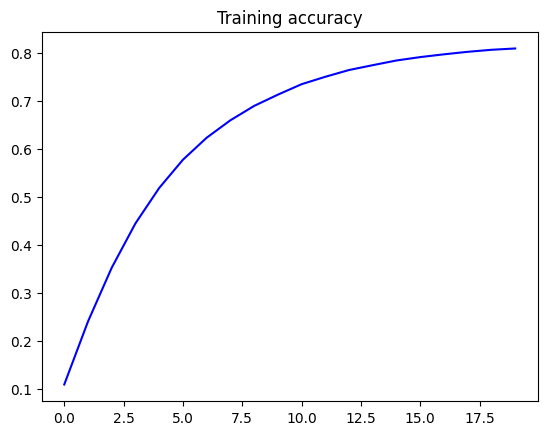

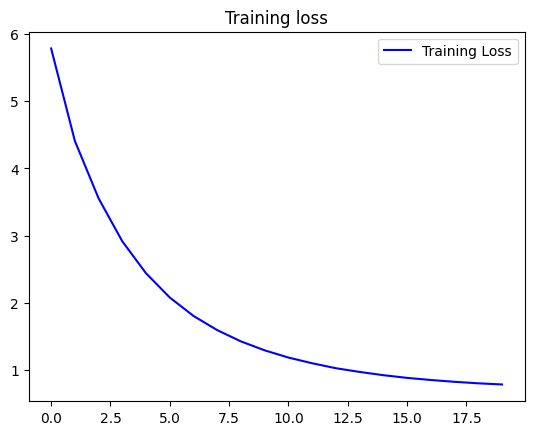

In [20]:
# Take a look at the training curves of your model

acc = history.history['accuracy']
loss = history.history['loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.title('Training accuracy')

plt.figure()

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.title('Training loss')
plt.legend()

plt.show()

In [21]:
def download_history():
  import pickle
  from google.colab import files

  with open('history.pkl', 'wb') as f:
    pickle.dump(history.history, f)

  files.download('history.pkl')

download_history()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [22]:
seed_text = test_text[0]
next_words = 100

for _ in range(next_words):
    # Convert the text into sequences
    token_list = tokenizer.texts_to_sequences([seed_text])[0]
    # Pad the sequences
    token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
    # Get the probabilities of predicting a word
    predicted = model.predict(token_list, verbose=0)
    # Choose the next word based on the maximum probability
    predicted = np.argmax(predicted, axis=-1).item()
    # Get the actual word from the word index
    output_word = tokenizer.index_word[predicted]
    # Append to the current text
    seed_text += " " + output_word

print(seed_text)

I am not the kind of girl in a new new new meminerim me to me to my stranger on all feel a friend to be true we on the way and take the things i shew'd you all get the rest of the don’t your life who don't see my own breath on the best way home you made me some things just see that you see the best will see you here then you don’t change my friends who are more for you a change in your friends and your friend go life to be straight led at way home you from me to the
